# Global Water Watch - test API
***

In [65]:
import pandas as pd
import geopandas as gpd
import json
import shapely
import matplotlib.pyplot as plt
from pathlib import Path

from gwwapi import client
from gwwapi import utils

## GRanD

In [66]:
path_grand = Path('Z:/nahaUsers/casadje/datasets/reservoirs/GRanD/v1_3')

In [67]:
grand = gpd.read_file(path_grand / 'GRanD_reservoirs_v1_3.shp').set_index('GRAND_ID')

## Embalse de la Serena (GRanD ID 2833)

In [43]:
ID = 89296

# retrieve information
geojson = client.get_reservoir_by_id(ID)
# Create the GeoDataFrame
geometry = shapely.geometry.shape(geojson['geometry'])
gdf = gpd.GeoDataFrame([geojson['properties']], geometry=[geometry], crs="EPSG:4326")

In [71]:
grand_id = gdf.iloc[0].grand_id

In [41]:
gdf

,name,name_en,grand_id,source_name,source_id,geometry
0,None,None,2833,HydroLAKES,14653,"MULTIPOLYGON (((-5.41958 38.90905, -5.41958 38..."


<Axes: >

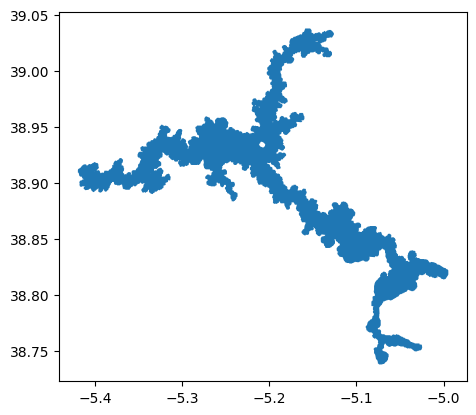

In [42]:
gdf.plot()

In [54]:
gdf.iloc[0].geometry.area

0.017656277273302892

In [83]:
ts = client.get_reservoir_ts_monthly(
    reservoir_id=ID
)
ts = pd.DataFrame.from_dict(ts).set_index('t')
ts.rename(columns={'value': 'area_sm'}, inplace=True)
ts.index = pd.to_datetime(ts.index)
ts.index.name = 'Timestamp'
ts.drop(['name', 'unit'], axis=1, inplace=True)

In [60]:
# ts.name.value_counts()

In [84]:
ts.head()

,area_sm
Timestamp,
2000-01-01,9.931084e+07
2000-02-01,9.611224e+07
2000-03-01,9.270840e+07
2000-04-01,9.270881e+07
2000-05-01,9.271017e+07


'GRanD 2833 - La Serena'

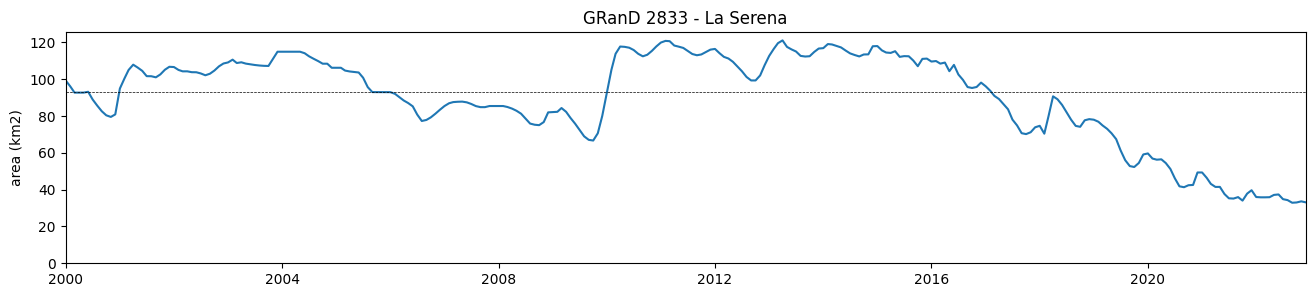

In [93]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(ts.area_sm * 1e-6)
ax.axhline(grand.loc[grand_id, 'AREA_SKM'], c='k', ls='--', lw=.5)
ax.set(
    xlim=(ts.index.min(), ts.index.max()),
    ylim=(0, None),
    ylabel='area (km2)',
    title='GRanD {0} - {1}'.format(grand_id, grand.loc[grand_id, 'DAM_NAME'])
);

***

In [24]:
res_geojson = get_reservoirs(limit=5)
res_gdf = gpd.GeoDataFrame.from_features(res_geojson['features'])
res_gdf.set_crs(epsg=4326, inplace=True)

,geometry,name,name_en,grand_id,source_name,source_id
0,"MULTIPOLYGON (((116.01547 -33.9787, 116.01548 ...",None,None,None,osm_way,472241910
1,"MULTIPOLYGON (((143.30933 -37.51787, 143.30944...",None,None,None,osm_way,128404442
2,"MULTIPOLYGON (((57.09841 29.46699, 57.0985 29....",None,None,None,osm_way,586026563
3,"MULTIPOLYGON (((5.8749 51.93421, 5.87494 51.93...",None,None,None,osm_way,345356771
4,"MULTIPOLYGON (((-117.34945 43.71732, -117.3492...",None,None,None,osm_way,553164798


<Axes: >

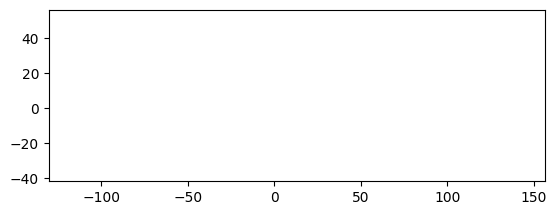

In [25]:
res_gdf.plot()

In [21]:
import geopandas as gpd
import json

# Your GeoJSON-like dictionary
geojson_data = { ... }  # (paste the full dictionary here)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(geojson_data["features"])

# Optionally set a CRS (usually EPSG:4326 for lat/lon)
gdf.set_crs(epsg=4326, inplace=True)

# Check the result
print(gdf.head())


{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'coordinates': [[[[116.01546878255273, -33.97870232211756],
       [116.01547771233085, -33.97821624958619],
       [116.01613319327957, -33.97822071919705],
       [116.01622682039329, -33.978506124849794],
       [116.01612426352418, -33.978706789992096],
       [116.01546878255273, -33.97870232211756]]]],
    'type': 'MultiPolygon'},
   'properties': {'name': None,
    'name_en': None,
    'grand_id': None,
    'source_name': 'osm_way',
    'source_id': 472241910},
   'id': '3',
   'bbox': None},
  {'type': 'Feature',
   'geometry': {'coordinates': [[[[143.3093320093207, -37.517868500738096],
       [143.30943898335215, -37.517676746590546],
       [143.30989831513168, -37.51761880488979],
       [143.31018813502823, -37.5177703684869],
       [143.31037542412446, -37.51822970950033],
       [143.31027289233768, -37.51842143914914],
       [143.3097021401233, -37.518416958065956],
       [143.30933200932

In [16]:
reservoirs.keys()

dict_keys(['type', 'features', 'bbox'])

In [18]:
len(reservoirs['features'])

50